In [ ]:
# 주의! ray를 pytorch보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import torch
import torch.nn as nn
import torch.nn.functional as F

import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 프로젝트 경로 설정
PROJECT_PATH = '.'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH_HOURGLASS = os.path.join(PROJECT_PATH, 'models_Hourglass')
MODEL_PATH_SIMPLEBASELINE = os.path.join(PROJECT_PATH, 'models_SimpleBaseline')
PT_RECORD_PATH = os.path.join(PROJECT_PATH, 'ptrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

# 1. 데이터 전처리

<json 파싱>  
- 샘플로 annotation 정보를 1개만 출력  
- json.dumps()를 활용해서 좀 더 명확하게 출력  
- 내용
    - joints_vis  
        - 실제로 사용할 수 있는 keypoint 인지 나타냄  
        - 이미지 형상과 사람의 포즈에 따라 모든 label 이 이미지에 나타나지 않기 때문  
        - MPII 의 경우 1 (visible) / 0(non)  
        - coco 의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label  
    - joints  
        - label 로 사용할 keypoint 의 label  
        - 순서  
            0 - 오른쪽 발목  
            1 - 오른쪽 무릎  
            2 - 오른쪽 엉덩이  
            3 - 왼쪽 엉덩이  
            4 - 왼쪽 무릎  
            5 - 왼쪽 발목  
            6 - 골반  
            7 - 가슴(흉부)  
            8 - 목  
            9 - 머리 위  
            10 - 오른쪽 손목  
            11 - 오른쪽 팔꿈치  
            12 - 오른쪽 어깨  
            13 - 왼쪽 어깨  
            14 - 왼쪽 팔꿈치  
            15 - 왼쪽 손목  
    - scale  
        - 사람 몸의 크기  
        - scale은 200을 곱해야 온전한 크기가 됨  
        - 전처리 과정에서 200을 곱해서 사용  
    - center  
        - 사람 몸의 중심점  

In [2]:
###################################
# json 살펴보기
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)


###################################
# json annotation 파싱
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

# parse_one_annotation()함수 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}
{'filename': '015601864.jpg', 'filepath': './images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

# 2. DataLoader

### 2.1 전처리(1)- annotation을 .pt 파일로 변환

In [3]:
####################################################
# 목표: 앞서 추출한 annotation을 .pt로 변환하는 함수  
# - 의미 있는 정보만 추출(직렬화)
####################################################

####################################################
# 하나의 annotation이 generate_ptexample()을 통해 PyTorch 형식으로 변환
def generate_ptexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']

    # 이미지 파일 읽기
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    # JPEG 형식 및 RGB 모드가 아니면 변환
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [int(joint[0]) if joint[0] >= 0 else int(joint[0])
         for joint in anno['joints']]
    y = [int(joint[1]) if joint[1] >= 0 else int(joint[0])
         for joint in anno['joints']]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height': height,
        'image/width': width,
        'image/depth': depth,
        'image/object/parts/x': x,
        'image/object/parts/y': y,
        'image/object/center/x': c_x,
        'image/object/center/y': c_y,
        'image/object/scale': scale,
        'image/object/parts/v': v,
        'image/encoded': content,
        'image/filename': filename.encode()  # bytes로 저장
    }

    return feature


###############################################################
# 전체 데이터를 여러 개의 그룹으로 나누는 함수
# - 전체 데이터를 n개의 그룹으로 나눈 후,
# - 결과적으로 n개의 .pt 파일을 생성
# - 하나의 .pt 파일을 만들지 않고, 여러 개로 나누어 저장할 예정
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results
#----------------------------------------
# chunkify함수 테스트  
# 0이 1000개 들어 있는 리스트가 64개로 쪼개짐을 확인
#----------------------------------------
# test_chunks = chunkify([0] * 1000, 64)
# print(test_chunks)
# print(len(test_chunks))
# print(len(test_chunks[0]))
# <출력 확인>
# [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
# 64
# 15


##################################################################
# 하나의 chunk를 .pt로 만들어 줄 함수
# - chunk안에는 여러 annotation들이 있고,
# - annotation들은 generate_ptexample()로 변환된 후에
# - 문자열로 직렬화되어 .pt 파일에 담긴다.
#
# @ray.remote
# - Ray: 병렬 처리를 위한 라이브러리
# - 파이썬에서 기본적으로 제공하는 multiprocessing 패키지보다 편하게 다양한 환경에서 사용가능
import pickle

@ray.remote
def build_single_ptrecord(chunk, path):
    print('start to build ptrecord for ' + path)

    with open(path, 'wb') as writer:
        for anno in chunk:
            ptexample = generate_ptexample(anno)
            pickle.dump(ptexample, writer)

    print('finished building ptrecord for ' + path)


##################################################################
# 전체 데이터를 적당한 수의 .pt 파일로 만들어주는 함수
# - ray를 사용하기 때문에 함수를 호출하는 문법이 약간 다르다
def build_pt_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_ptrecord.remote(
            chunk, '{}/{}_{}_of_{}.ptrecords'.format(
                PT_RECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )
        ) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)


##################################################################
# 실행
# ptrecord 생성
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(PT_RECORD_PATH):
    os.makedirs(PT_RECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])

print('Start to build PT Records.')
build_pt_records(train_annotations, num_train_shards, 'train')
build_pt_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to PT Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-12-04 05:57:00,120	INFO worker.py:2023 -- Started a local Ray instance.
/home/jacksju/anaconda3/envs/case1_study/lib/python3.12/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': './images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': './images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'center': [966.0, 340.0], 'scale': 4.7

### 2.2 전처리(2)  

- image_tensor  
    - 정규화[-1, 1] 된 이미지, (C, H, W) 순서  
- heatmaps  

In [4]:
import torch
from PIL import Image
import io
import numpy as np

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape      # (height, width, channels)
        self.heatmap_shape = heatmap_shape  # (height, width, num_heatmap)

    def __call__(self, example):
        features = self.parse_tfexample(example)
        # image 데이터를 다시 bytes로 디코딩 후 재로딩 (JPEG 형식)
        image = Image.open(io.BytesIO(features['image/encoded']))

        if self.is_train:
            # 0.1 ~ 0.3 사이의 random margin 생성
            random_margin = torch.empty(1).uniform_(0.1, 0.3).item()
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = image.resize((self.image_shape[1], self.image_shape[0]))
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = image.resize((self.image_shape[1], self.image_shape[0]))

        # 이미지 정규화: uint8 → [0,255] → [-1, 1]
        image_np = np.array(image).astype(np.float32)
        image_np = image_np / 127.5 - 1.0
        # 채널 우선순서로 변환: (H, W, C) -> (C, H, W)
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)

        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image_tensor, heatmaps

    def parse_tfexample(self, example):
        """
        MPIIDataset에서 전달한 예제를 받아, Preprocessor가 처리할 수 있도록 features dict를 구성합니다.
        예제 형식: {'image': PIL.Image, 'annotation': anno}
        
        .pt로 저장된 데이터를 모델 학습에 필요한 데이터로 바꿔줄 함수가 필요한데,
        이는 PyTorch에서 이미 제공해주는 함수를 사용하면 되기 때문에 간단하다.
        주의할 점은 .pt가 직렬화된 데이터이기 때문에
        만들 때 데이터 순서와 읽어올 때 데이터 순서와 형식이 같아야 한다는 점이다.
        """
        annotation = example['annotation']
        # joints: list of [x, y]
        joints = annotation['joints']
        keypoint_x = [joint[0] for joint in joints]
        keypoint_y = [joint[1] for joint in joints]

        # joints_vis가 없으면 모든 관절이 가시적이라고 가정 (1)
        joints_vis = annotation.get('joints_vis', [1] * len(joints))

        features = {
            'image/encoded': self.image_to_bytes(example['image']),
            'image/object/parts/x': keypoint_x,
            'image/object/parts/y': keypoint_y,
            'image/object/parts/v': joints_vis,
            'image/object/center/x': annotation['center'][0],
            'image/object/center/y': annotation['center'][1],
            'image/object/scale': annotation['scale'],
        }
        return features

    def image_to_bytes(self, image):
        """
        PIL.Image 객체를 JPEG 인코딩된 bytes로 변환합니다.
        """
        buffer = io.BytesIO()
        image.save(buffer, format="JPEG")
        return buffer.getvalue()

    def crop_roi(self, image, features, margin=0.2):
        """
        얻은 image 와 label 을 이용해서 적절한 학습 형태로 변환한다.
        이미지를 그대로 사용하지 않고 적당히 정사각형으로 crop하여 사용한다.
        알고 있는 것- joints 의 위치, center 의 좌표, body height 값
        
        균일하게 학습하기 위해 body width 를 적절히 정하는 것도 중요
        (여러 방법이 있을 수 있겠지만)
        임의로 조정한 crop box 가 이미지 바깥으로 나가지 않는지 예외 처리까지만 하자
        """
        # image: PIL.Image, features: dict
        img_width, img_height = image.size  # PIL: (width, height)

        keypoint_x = torch.tensor(features['image/object/parts/x'], dtype=torch.int32)
        keypoint_y = torch.tensor(features['image/object/parts/y'], dtype=torch.int32)
        body_height = features['image/object/scale'] * 200.0

        # 유효한 keypoint (값 > 0)만 선택
        masked_keypoint_x = keypoint_x[keypoint_x > 0]
        masked_keypoint_y = keypoint_y[keypoint_y > 0]
        
        # 최소, 최대 값 계산 (유효한 keypoint가 하나 이상 있다고 가정)
        keypoint_xmin = int(masked_keypoint_x.min().item())
        keypoint_xmax = int(masked_keypoint_x.max().item())
        keypoint_ymin = int(masked_keypoint_y.min().item())
        keypoint_ymax = int(masked_keypoint_y.max().item())

        # margin을 적용하여 경계를 확장 (body_height * margin 값을 정수로 캐스팅)
        extra = int(body_height * margin)
        xmin = keypoint_xmin - extra
        xmax = keypoint_xmax + extra
        ymin = keypoint_ymin - extra
        ymax = keypoint_ymax + extra

        # 이미지 경계를 벗어나지 않도록 조정
        effective_xmin = max(xmin, 0)
        effective_ymin = max(ymin, 0)
        effective_xmax = min(xmax, img_width)
        effective_ymax = min(ymax, img_height)

        # 이미지 크기 재조정
        cropped_image = image.crop((effective_xmin, effective_ymin, effective_xmax, effective_ymax))
        new_width = effective_xmax - effective_xmin
        new_height = effective_ymax - effective_ymin

        # keypoint 좌표를 정규화 (0~1 범위)
        effective_keypoint_x = (keypoint_x.float() - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y.float() - effective_ymin) / new_height

        return cropped_image, effective_keypoint_x, effective_keypoint_y

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        """
        (x, y) 좌표로 되어있는 keypoint 를 heatmap 으로 변경
        - 하나의 점에만 표시 되어있는 정보를 좌표 근처 여러 지점에 확률 분포 형태로 학습시키면 결과가 더 좋았다.
        - 이런 확률 분표 형태의 정보를 heatmap이라고 한다.
        """
        
        # (height, width) 크기의 0으로 채워진 heatmap 생성
        heatmap = torch.zeros((height, width), dtype=torch.float32)

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        # 범위가 이미지 내에 없거나, visibility가 0이면 heatmap 그대로 반환
        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            return heatmap

        size = int(6 * sigma + 1)
        grid_range = torch.arange(0, size, dtype=torch.float32)
        x_grid, y_grid = torch.meshgrid(grid_range, grid_range, indexing='xy')
        center_x = size // 2
        center_y = size // 2

        # 가우시안 patch 계산
        gaussian_patch = torch.exp(-(((x_grid - center_x)**2 + (y_grid - center_y)**2) / (2 * sigma**2))) * scale

        # 이미지와 patch 간의 겹치는 영역 계산
        patch_xmin = max(0, -xmin)
        patch_ymin = max(0, -ymin)
        patch_xmax = min(xmax, width) - xmin
        patch_ymax = min(ymax, height) - ymin

        heatmap_xmin = max(0, xmin)
        heatmap_ymin = max(0, ymin)
        heatmap_xmax = min(xmax, width)
        heatmap_ymax = min(ymax, height)

        # 계산된 영역에 gaussian_patch 값을 할당
        heatmap[heatmap_ymin:heatmap_ymax, heatmap_xmin:heatmap_xmax] = \
            gaussian_patch[int(patch_ymin):int(patch_ymax), int(patch_xmin):int(patch_xmax)]

        return heatmap

    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        # heatmap_shape: (height, width, num_heatmap)
        v = torch.tensor(features['image/object/parts/v'], dtype=torch.float32)
        x = torch.round(keypoint_x * heatmap_shape[1]).to(torch.int32)  # width: heatmap_shape[1]
        y = torch.round(keypoint_y * heatmap_shape[0]).to(torch.int32)  # height: heatmap_shape[0]

        num_heatmap = heatmap_shape[2]
        heatmaps_list = []

        for i in range(num_heatmap):
            # generate_2d_gaussian 함수 호출 시, height=heatmap_shape[1], width=heatmap_shape[0]
            gaussian = self.generate_2d_guassian(
                height=heatmap_shape[0],
                width=heatmap_shape[1],
                y0=int(y[i].item()),
                x0=int(x[i].item()),
                visibility=int(v[i].item())
            )
            heatmaps_list.append(gaussian)

        # 스택 후, (num_heatmap, height, width) 형태로 반환
        heatmaps = torch.stack(heatmaps_list, dim=0)
        return heatmaps

(build_single_ptrecord pid=317226) finished building ptrecord for ./ptrecords_mpii/val_0008_of_0008.ptrecords


### 2.3 Data set, Data Loader

In [5]:
##################################################################
# Data SET
from torch.utils.data import Dataset

class MPIIDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # JSON 파일을 읽어 annotations 리스트 생성
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)

        # 각 annotation을 파싱하여 리스트에 저장
        self.annotations = [parse_one_annotation(anno, image_dir) for anno in annotations]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        # 이미지 파일 경로로부터 이미지를 로드 (RGB 모드로 변환)
        image = Image.open(anno['filepath']).convert('RGB')

        # transform이 있으면 적용
        if self.transform:
            image, heatmaps = self.transform({'image': image, 'annotation': anno})
            return image, heatmaps
        else:
            # transform이 없으면 원본 이미지와 annotation dict 반환
            return image, anno

##################################################################
# Data Loader
# - .pt 파일이 여러개이므로 torch.utils.data.DataLoader를 통해 불러온다.

from torch.utils.data import DataLoader

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataloader(annotation_file, image_dir, batch_size, num_heatmap, is_train=True):
    """
    annotation_file: JSON 파일 경로 (예: train.json)
    image_dir: 이미지 파일들이 저장된 디렉토리 경로
    batch_size: 배치 크기
    num_heatmap: 생성할 heatmap 개수
    is_train: True이면 shuffle 적용
    """

    preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap),
        is_train=is_train
    )

    dataset = MPIIDataset(annotation_file=annotation_file, image_dir=image_dir, transform=preprocess)

    # DataLoader 생성
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=is_train,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        prefetch_factor=4, #prefetch_factor=2
        persistent_workers=True
    )

    return dataloader

# 3. 학습 엔진 (Trainer)
- class Trainer: nn.DataParallel을 이용하여 Multi-GPU를 사용하는 trainer
- def train(): 학습 parameter를 세팅하고 class Trainer호출 하여 학습하는 함수

In [6]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import time

class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 initial_learning_rate,
                 save_path):
        """
        - model: 학습시킬 PyTorch 모델(nn.Module)
        - epochs: 전체 학습 epoch 수
        - global_batch_size: 전체 배치 크기 (loss 계산 시 사용)
        - initial_learning_rate: 초기 학습률
        """
        self.model = model
        self.epochs = epochs
        self.global_batch_size = global_batch_size

        # MSE loss를 reduction='none'으로 사용 (가중치 적용을 위해)
        self.loss_object = nn.MSELoss(reduction='none')

        # Adam optimizer 초기화
        self.optimizer = optim.Adam(self.model.parameters(), lr=initial_learning_rate)

        # 학습률 스케줄링 관련 변수들
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10

        # 최적 모델 체크포인트 저장
        self.best_model = None

        # 단일 GPU/멀티 GPU(DataParallel) 설정
        if torch.cuda.device_count() > 1:
            print(f"멀티 GPU 사용 (GPU 개수: {torch.cuda.device_count()})")
            self.model = nn.DataParallel(self.model)
        else:
            print("단일 GPU 혹은 CPU 사용")
        
        self.save_path=save_path

    def lr_decay(self):
        """
        patience_count가 max_patience를 넘으면 학습률을 1/10으로 감소,
        그렇지 않고 val_loss가 그대로면 patience_count += 1,
        새 최저 val_loss를 달성하면 patience_count를 0으로.
        """
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0

        self.patience_count += 1

        # optimizer의 learning rate 갱신
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def lr_decay_step(self, epoch):
        """
        25, 50, 75 epoch에서 학습률을 1/10으로 감소시키는 스케줄링.
        """
        if epoch in [25, 50, 75]:
            self.current_learning_rate /= 10.0

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        """
        여러 스택의 heatmap 출력(outputs)에 대해 MSE를 구하되,
        labels > 0인 위치에는 81의 추가 가중치를 적용.
        """
        loss = 0
        for output in outputs:
            # labels > 0 이면 81 + 1 = 82, 아니면 1
            weights = (labels > 0).float() * 81 + 1
            squared_error = (labels - output) ** 2
            weighted_error = squared_error * weights
            # 전체 배치에 대한 평균 후, global_batch_size로 나눔
            loss += weighted_error.mean() / self.global_batch_size
        return loss

    def train_step(self, images, labels, device):
        self.model.train()
        images = images.to(device)
        labels = labels.to(device)

        self.optimizer.zero_grad()
        outputs = self.model(images)
        loss = self.compute_loss(labels, outputs)
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def val_step(self, images, labels, device):
        self.model.eval()
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            loss = self.compute_loss(labels, outputs)
        return loss.item()

    def run(self, train_loader, val_loader, device):
        """
        - train_loader, val_loader: PyTorch DataLoader
        - device: torch.device('cuda' or 'cpu')
        """
        lenOfbatch_train=len(train_loader)
        lenOfbatch_valid=len(val_loader)
        for epoch in range(1, self.epochs + 1):
            start_time = time.time()

            # 학습률 감소 로직
            self.lr_decay()
            print(f"Start epoch {epoch} with learning rate {self.current_learning_rate:.6f}")

            # Training
            total_train_loss = 0.0
            num_train_batches = 0
            for images, labels in train_loader:
                batch_loss = self.train_step(images, labels, device)
                total_train_loss += batch_loss
                num_train_batches += 1
                print(f"[Train] batch {num_train_batches}/{lenOfbatch_train} loss {batch_loss:.4f} "
                      f"avg_loss {total_train_loss/num_train_batches:.4f}")
            train_loss = total_train_loss / num_train_batches
            print(f"Epoch {epoch} train loss {train_loss:.4f}")

            # Validation
            total_val_loss = 0.0
            num_val_batches = 0
            for images, labels in val_loader:
                batch_loss = self.val_step(images, labels, device)
                num_val_batches += 1
                print(f"[Val] batch {num_val_batches}/{lenOfbatch_valid} loss {batch_loss:.4f}")
                # NaN이 아닌 경우만 합산
                if not math.isnan(batch_loss):
                    total_val_loss += batch_loss
                else:
                    num_val_batches -= 1

            if num_val_batches > 0:
                val_loss = total_val_loss / num_val_batches
            else:
                val_loss = float('nan')

            end_time = time.time()
            epoch_duration = end_time - start_time
            print(f"Epoch {epoch} val loss {val_loss:.4f} time {epoch_duration}sec")

            # 새로운 최저 val_loss 달성 시 모델 저장
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = os.path.join(self.save_path, f'model-epoch-{epoch}-loss-{loss:.4f}.pt')
        torch.save(self.model.state_dict(), model_name)
        self.best_model = model_name
        print(f"Model {model_name} saved.")


def train(model, epochs, learning_rate, num_heatmap, batch_size, train_annotation_file, val_annotation_file, image_dir, model_path):
    """
    - epochs: 전체 학습 epoch 수
    - learning_rate: 초기 학습률
    - num_heatmap: 생성할 heatmap 개수
    - batch_size: 배치 크기
    - train_annotation_file: train.json 파일 경로
    - val_annotation_file: validation.json 파일 경로
    - image_dir: 이미지 파일들이 저장된 디렉토리 경로
    """
    global_batch_size = batch_size

    train_loader = create_dataloader(train_annotation_file, image_dir, batch_size, num_heatmap, is_train=True)
    val_loader = create_dataloader(val_annotation_file, image_dir, batch_size, num_heatmap, is_train=False)

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trainer = Trainer(
        model,
        epochs,
        global_batch_size,
        initial_learning_rate=learning_rate,
        save_path=model_path
    )

    print("Start training...")
    return trainer.run(train_loader, val_loader, device)

# 4. Hourglass 모델
<img src='./markdown_fig/hourglass.png' width='400'>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, filters, stride=1, downsample=False):
        super(BottleneckBlock, self).__init__()
        self.downsample = downsample
        # 만약 downsample이라면 identity branch에 1x1 conv 적용하여 채널 수와 spatial size 조정
        if self.downsample:
            self.downsample_conv = nn.Conv2d(in_channels, filters, kernel_size=1, stride=stride, bias=False)

        # main branch
        self.bn1 = nn.BatchNorm2d(in_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, filters // 2, kernel_size=1, stride=1, padding=0, bias=False)

        self.bn2 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        # kernel_size=3, padding=1로 'same' padding 효과
        self.conv2 = nn.Conv2d(filters // 2, filters // 2, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        self.conv3 = nn.Conv2d(filters // 2, filters, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample_conv(x)

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        out += identity
        return out


#####################################################
# hourglass 모델을 잘 생각해 보면
# 마치 양파처럼 가장 바깥의 layer 를 제거하면 똑같은 구조가 나타나는 것을 알 수 있다.
# 이 점을 이용해서 간단하게 모델을 표현할 수 있다.
#
# 재귀 함수를 이용!
# 바깥부터 5개의 양파껍질(층)을 만들고 싶다면
# order 를 이용해서 5,4...1 이 될 때까지 HourglassModule 을 반복하다가
# order 가 1이 되면 BottleneckBlock 으로 대체해 주면 된다.

class HourglassModule(nn.Module):
    def __init__(self, order, filters, num_residual):
        super(HourglassModule, self).__init__()
        self.order = order

        # Up branch: BottleneckBlock 1회 + num_residual회 반복
        self.up1_0 = BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
        self.up1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Low branch: MaxPool + num_residual BottleneckBlock
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.low1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Recursive hourglass or additional BottleneckBlocks
        if order > 1:
            self.low2 = HourglassModule(order - 1, filters, num_residual)
        else:
            self.low2_blocks = nn.Sequential(*[
                BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
                for _ in range(num_residual)
            ])

        # 후처리 BottleneckBlock 반복
        self.low3_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # UpSampling (최근접 보간법)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        # up branch
        up1 = self.up1_0(x)
        up1 = self.up1_blocks(up1)

        # low branch
        low1 = self.pool(x)
        low1 = self.low1_blocks(low1)
        if self.order > 1:
            low2 = self.low2(low1)
        else:
            low2 = self.low2_blocks(low1)
        low3 = self.low3_blocks(low2)
        up2 = self.upsample(low3)

        return up2 + up1


class LinearLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinearLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # He (Kaiming) 초기화 적용
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class StackedHourglassNetwork(nn.Module):
    def __init__(self, input_shape=(256, 256, 3), num_stack=4, num_residual=1, num_heatmap=16):
        super(StackedHourglassNetwork, self).__init__()
        self.num_stack = num_stack

        in_channels = input_shape[2]  # 3
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck blocks 초기화
        # BottleneckBlock의 첫번째 호출: 64 → 128, downsample=True
        self.bottleneck1 = BottleneckBlock(in_channels=64, filters=128, stride=1, downsample=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 두 번째: 128 → 128, downsample=False
        self.bottleneck2 = BottleneckBlock(in_channels=128, filters=128, stride=1, downsample=False)
        # 세 번째: 128 → 256, downsample=True
        self.bottleneck3 = BottleneckBlock(in_channels=128, filters=256, stride=1, downsample=True)

        # 스택 구성 요소들
        self.hourglass_modules = nn.ModuleList()
        self.residual_modules = nn.ModuleList()  # hourglass 후 residual block들 (num_residual회)
        self.linear_layers = nn.ModuleList()
        self.heatmap_convs = nn.ModuleList()
        # 마지막 스택을 제외한 중간 피쳐 결합용 1x1 conv
        self.intermediate_convs = nn.ModuleList()
        self.intermediate_outs = nn.ModuleList()

        for i in range(num_stack):
            # order=4인 hourglass 모듈 (앞에서 정의한 HourglassModule 사용)
            self.hourglass_modules.append(HourglassModule(order=4, filters=256, num_residual=num_residual))
            # hourglass 후 residual block들
            self.residual_modules.append(nn.Sequential(*[
                BottleneckBlock(in_channels=256, filters=256, stride=1, downsample=False)
                for _ in range(num_residual)
            ]))
            # Linear layer: 1x1 conv + BN + ReLU (앞에서 정의한 LinearLayer 사용)
            self.linear_layers.append(LinearLayer(in_channels=256, out_channels=256))
            # 최종 heatmap을 생성하는 1x1 conv
            self.heatmap_convs.append(nn.Conv2d(256, num_heatmap, kernel_size=1, stride=1, padding=0))

            if i < num_stack - 1:
                self.intermediate_convs.append(nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
                self.intermediate_outs.append(nn.Conv2d(num_heatmap, 256, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        # x: (B, 3, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.bottleneck1(x)
        x = self.pool(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)

        outputs = []
        for i in range(self.num_stack):
            hg = self.hourglass_modules[i](x)
            res = self.residual_modules[i](hg)
            lin = self.linear_layers[i](res)
            heatmap = self.heatmap_convs[i](lin)
            outputs.append(heatmap)

            if i < self.num_stack - 1:
                inter1 = self.intermediate_convs[i](lin)
                inter2 = self.intermediate_outs[i](heatmap)
                x = inter1 + inter2  # 다음 스택의 입력으로 사용

        return outputs

# 5. SimpleBaseline 모델
<img src='./markdown_fig/simplebaseline.png' width='400'>

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

class DeconvLayer(nn.Module):
    def __init__(self, num_deconv_layers):
        super(DeconvLayer, self).__init__()
        layers = []
        for _ in range(num_deconv_layers):
            layers.append(nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(256))
            layers.append(nn.ReLU())
        self.deconv_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.deconv_layers(x)

class SimpleBaseline(nn.Module):
    def __init__(self, num_heatmap=16): # num_heatmap 인자 추가
        super(SimpleBaseline, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # ResNet의 마지막 pooling과 fc layer 제거
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        self.reduce_channels = nn.Conv2d(2048, 256, kernel_size=1)
        self.upconv = DeconvLayer(3)
        # num_heatmap 변수 사용 (MPII는 보통 16)
        self.final_layer = nn.Conv2d(256, num_heatmap, kernel_size=1, padding=0)

    def forward(self, x):
        x = self.resnet(x)
        x = self.reduce_channels(x)
        x = self.upconv(x)
        x = self.final_layer(x)
        # Trainer의 compute_loss가 리스트를 순회하므로 리스트로 감싸서 반환해야 함
        return [x]

# 6. 결과물 그림 그리기 함수

In [9]:
####################################################################
# 학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정
# 변수에 저장되는 것은 해당 부위를 나타내는 인덱스

R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]


####################################################################
# heatmap에서 최대값을 찾는 함수
#
# - 모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꿨다.
# - 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap이다.
# - 그래서 이 heatmap으로부터 좌표를 추출해야 한다.
# -> heatmap중에 최대값을 갖는 지점을 찾아내면 된다.
def find_max_coordinates(heatmaps):
    # heatmaps: (H, W, C)
    H, W, C = heatmaps.shape
    # reshape to (H*W, C)
    flatten_heatmaps = heatmaps.reshape(-1, C)
    # 각 채널 별 최대값 인덱스 (flattened index)
    indices = torch.argmax(flatten_heatmaps, dim=0)
    # y 좌표: index // H, x 좌표: index - H * y
    y = indices // H
    x = indices - H * y
    # 반환: (C, 2) 텐서, 각 행이 [x, y] 좌표
    return torch.stack([x, y], dim=1)


####################################################################
# 위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때
# quantization 오차가 발생
# 실제 계산에서는 3x3 필터를 이용해서 근사치를 구한다.
def extract_keypoints_from_heatmap(heatmaps):
    """
    heatmaps: (H, W, C) 텐서 (예: (64,64,16))
    """
    H, W, C = heatmaps.shape
    max_keypoints = find_max_coordinates(heatmaps)  # shape: (C, 2) with [x, y] per channel

    # pad heatmaps: 먼저 (C, H, W)로 변환한 후 pad, 다시 (H+2, W+2, C)
    heatmaps_permuted = heatmaps.permute(2, 0, 1)  # (C, H, W)
    padded = F.pad(heatmaps_permuted, (1, 1, 1, 1))  # pad (left, right, top, bottom)
    padded_heatmaps = padded.permute(1, 2, 0)  # (H+2, W+2, C)

    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # 기존 keypoint의 좌표에 패딩 오프셋 추가
        max_x = int(keypoint[0].item()) + 1
        max_y = int(keypoint[1].item()) + 1

        # 3x3 패치를 추출 (채널 i)
        patch = padded_heatmaps[max_y-1:max_y+2, max_x-1:max_x+2, i]  # (3,3)
        # 중앙 값 제거
        patch[1, 1] = 0
        # 패치 내 최대값의 index를 찾음
        flat_patch = patch.reshape(-1)
        index = torch.argmax(flat_patch).item()

        next_y = index // 3
        next_x = index % 3
        delta_y = (next_y - 1) / 4.0
        delta_x = (next_x - 1) / 4.0

        adjusted_x = keypoint[0].item() + delta_x
        adjusted_y = keypoint[1].item() + delta_y
        adjusted_keypoints.append((adjusted_x, adjusted_y))

    # 리스트를 텐서로 변환하고 clip
    adjusted_keypoints = torch.tensor(adjusted_keypoints)
    adjusted_keypoints = torch.clamp(adjusted_keypoints, 0, H)
    normalized_keypoints = adjusted_keypoints / H
    return normalized_keypoints


####################################################################
# 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict(model, image_path):
    # 이미지 로드 (RGB 모드)
    image = Image.open(image_path).convert("RGB")

    # 전처리: 리사이즈, 텐서 변환, [-1, 1] 범위로 스케일링
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),         # 결과: [0, 1]
        transforms.Lambda(lambda x: x * 2 - 1)  # [0,1] -> [-1,1]
    ])
    inputs = preprocess(image)          # shape: (C, H, W)
    inputs = inputs.unsqueeze(0)        # 배치 차원 추가: (1, C, H, W)

    # 모델의 device에 맞게 입력을 이동시킵니다.
    device = next(model.parameters()).device
    inputs = inputs.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(inputs)         # outputs가 리스트가 아닐 수 있음

    if not isinstance(outputs, list):
        outputs = [outputs]

    # 마지막 스택의 결과를 사용한다고 가정 (출력 shape: (1, num_heatmap, H, W))
    heatmap_tensor = outputs[-1].squeeze(0)      # (num_heatmap, H, W)
    # extract_keypoints_from_heatmap 함수는 (H, W, num_heatmap) 형태를 기대하므로 차원 순서를 변경
    heatmap_tensor = heatmap_tensor.permute(1, 2, 0)  # (H, W, num_heatmap)

    # detach, CPU로 이동 후 extract_keypoints_from_heatmap에 전달
    heatmap = heatmap_tensor.detach().cpu()
    kp = extract_keypoints_from_heatmap(heatmap)

    return image, kp


####################################################################
# 결과물 그림 그리기
#
# 두 가지 그림- keypoint들과 뼈대
# keypoint: 관절 역할
# 뼈대: keypoint들을 연결시킨 것

import torch
import numpy as np
import matplotlib.pyplot as plt

def to_numpy_image(image):
    if torch.is_tensor(image):
        image_np = image.detach().cpu().numpy()
        # 이미지 채널이 첫 번째 차원이라면, (C, H, W) -> (H, W, C)
        if image_np.ndim == 3 and image_np.shape[0] == 3:
            image_np = np.transpose(image_np, (1, 2, 0))
    elif not isinstance(image, np.ndarray):
        # PIL.Image인 경우
        image_np = np.array(image)
    else:
        image_np = image
    return image_np

def draw_keypoints_on_image(image, keypoints, index=None):
    image_np = to_numpy_image(image)

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        if index is not None and index != i:
            continue
        ax.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    image_np = to_numpy_image(image)

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        joints.append((joint_x, joint_y))

    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        ax.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

def draw_keypoints_skeleton_on_image(image, keypoints, index=None):
    image_np = to_numpy_image(image)

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        if index is not None and index != i:
            continue
        ax.scatter(joint_x, joint_y, s=50, c='red', marker='o')
        joints.append((joint_x, joint_y))

    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        ax.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
        
    plt.show()

# 7. Hourglass 학습

In [10]:
import os

TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VAL_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')
IMAGE_DIR = os.path.join(PROJECT_PATH, 'images')

epochs = 20
batch_size = 44#2
num_heatmap = 16
learning_rate = 0.001

# best_model_file = train(StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap),
#                         epochs, learning_rate, num_heatmap, batch_size, 
#                         TRAIN_JSON, VAL_JSON, IMAGE_DIR,MODEL_PATH_HOURGLASS)

# 8. GPU 메모리 비우기

In [11]:
import gc
import torch

# 혹시 전역 변수에 model이 남아있다면 삭제 (안전장치)
if 'model' in globals():
    del model
#if 'trainer' in globals():
#    del trainer

# 1. 파이썬 가비지 컬렉션 강제 실행 (참조가 끊긴 변수들 메모리 해제)
gc.collect()

# 2. PyTorch 캐시 메모리 비우기 (GPU 메모리 확보)
torch.cuda.empty_cache()
print("GPU Memory Cleared!")
# ===========================

GPU Memory Cleared!


# 9. SimpleBaseline 학습

In [12]:
import os

TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VAL_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')
IMAGE_DIR = os.path.join(PROJECT_PATH, 'images')

epochs = 20
batch_size = 44#2
num_heatmap = 16
learning_rate = 0.001 # ResNet은 보통 1e-3 혹은 1e-4 정도로 시작

# best_model_file = train(SimpleBaseline(num_heatmap=num_heatmap),
#                         epochs, learning_rate, num_heatmap, batch_size, 
#                         TRAIN_JSON, VAL_JSON, IMAGE_DIR, MODEL_PATH_SIMPLEBASELINE)

# 10. 정성정 평가(결과 그림)

In [13]:
import torch
import random
import matplotlib.pyplot as plt

# 1. Validation Dataset 준비 (이전과 동일)
# heatmap_cnt = 16 # 만약 정의되지 않았다면 주석 해제
preprocess_val = Preprocessor(
    is_train=False
)

valid_dataset = MPIIDataset(
    annotation_file=VALID_JSON,
    image_dir=IMAGE_PATH,
    transform=preprocess_val
)

# 2. 비교 및 시각화 함수 정의
def compare_gt_and_pred(model, dataset, idx):
    # --- 데이터 로드 ---
    # dataset[idx]는 (image_tensor, gt_heatmaps)를 반환
    image_tensor, gt_heatmaps = dataset[idx]
    
    # --- 1) Ground Truth 처리 ---
    # gt_heatmaps shape: (C, H, W) -> (H, W, C)로 변환 (extract 함수 입력 형식 맞춤)
    gt_heatmaps_permuted = gt_heatmaps.permute(1, 2, 0)
    
    # 히트맵에서 좌표 추출
    gt_keypoints = extract_keypoints_from_heatmap(gt_heatmaps_permuted)

    # --- 2) Prediction 처리 ---
    # 배치 차원 추가 및 디바이스 이동
    inputs = image_tensor.unsqueeze(0)
    device = next(model.parameters()).device
    inputs = inputs.to(device)

    # 모델 추론
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        
    if not isinstance(outputs, list):
        outputs = [outputs]
    
    # 마지막 Stack의 히트맵 사용
    pred_heatmap = outputs[-1].squeeze(0) # (C, H, W)
    pred_heatmap = pred_heatmap.permute(1, 2, 0) # (H, W, C)
    
    # 좌표 추출
    pred_keypoints = extract_keypoints_from_heatmap(pred_heatmap.detach().cpu())

    # --- 3) 시각화 준비 ---
    # 이미지 정규화 해제: [-1, 1] -> [0, 1]
    image_vis = (image_tensor.clone() + 1) / 2.0
    image_vis = torch.clamp(image_vis, 0, 1)

    return image_vis, gt_keypoints, pred_keypoints

## 10.1. Hourglass 결과 그림

Validation Index: 1752

========== [Ground Truth] 정답 ==========


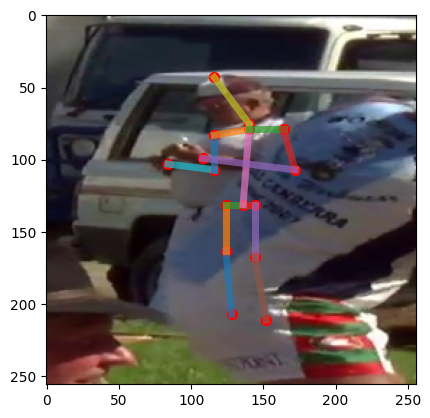


========== [Prediction] 모델 예측 ==========


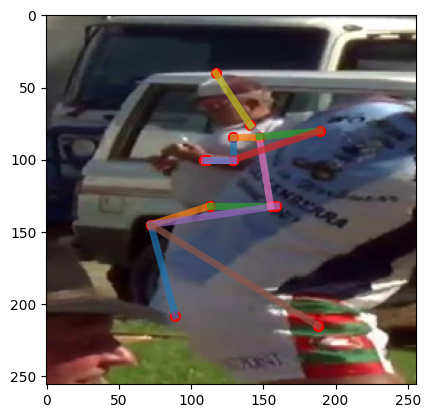

Validation Index: 2077

========== [Ground Truth] 정답 ==========


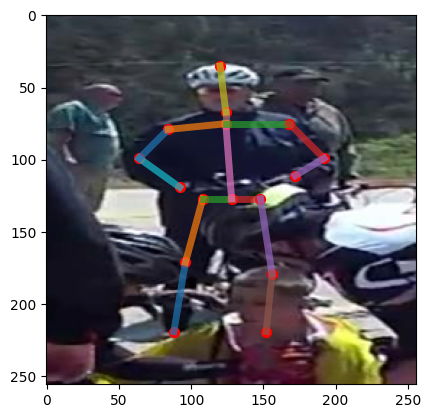


========== [Prediction] 모델 예측 ==========


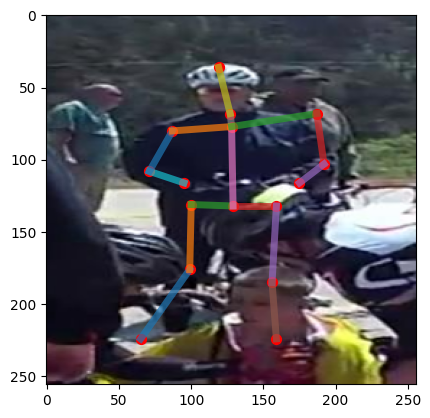

Validation Index: 1050

========== [Ground Truth] 정답 ==========


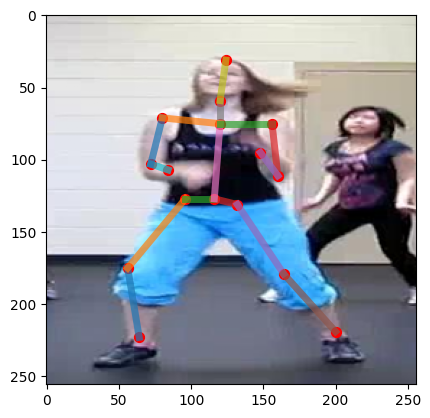


========== [Prediction] 모델 예측 ==========


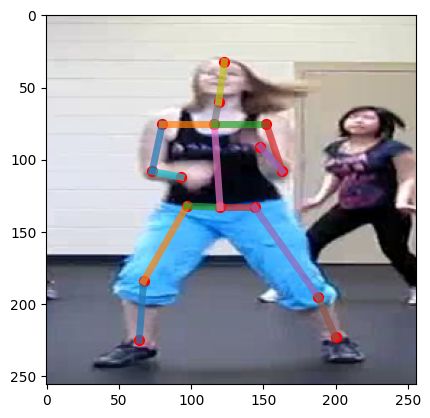

Validation Index: 1142

========== [Ground Truth] 정답 ==========


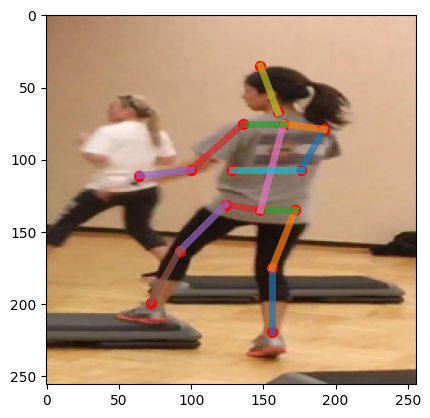


========== [Prediction] 모델 예측 ==========


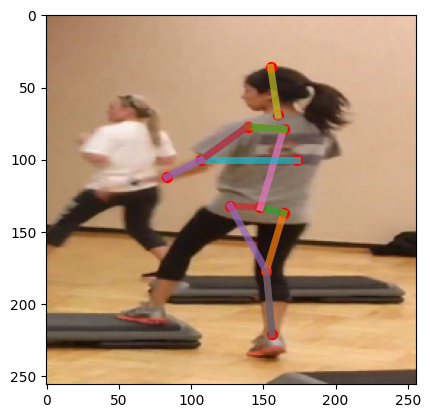

Validation Index: 1461

========== [Ground Truth] 정답 ==========


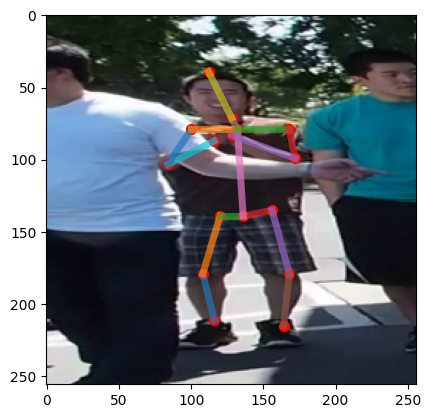


========== [Prediction] 모델 예측 ==========


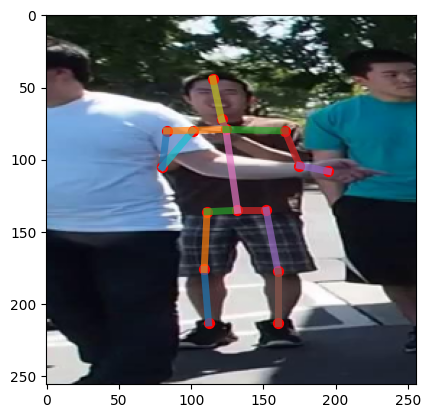

In [14]:
import os
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 저장된 가중치 불러오기
WEIGHTS_PATH = os.path.join(MODEL_PATH_HOURGLASS, 'model-epoch-15-loss-0.3941.pt')
checkpoint = torch.load(WEIGHTS_PATH, map_location=device)

# 2. 새로운 state_dict 생성 (접두사 제거)
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    # 'module.' 이라는 접두사가 있으면 제거 ('module.conv1.weight' -> 'conv1.weight')
    name = k.replace("module.", "") 
    new_state_dict[name] = v

# 3. 모델에 로드
model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
model.load_state_dict(new_state_dict)
model.to(device)
model.eval() # 평가 모드로 변경

# -------------------------------------------------------
# 결과 확인
# -------------------------------------------------------
for idx in [1752, 2077, 1050, 1142, 1461] :
    print(f"Validation Index: {idx}")
    # 데이터 가져오기
    img, gt_kp, pred_kp = compare_gt_and_pred(model, valid_dataset, idx)

    print("\n========== [Ground Truth] 정답 ==========")
    #draw_keypoints_on_image(img, gt_kp)
    #draw_skeleton_on_image(img, gt_kp)
    draw_keypoints_skeleton_on_image(img, gt_kp)

    print("\n========== [Prediction] 모델 예측 ==========")
    #draw_keypoints_on_image(img, pred_kp)
    #draw_skeleton_on_image(img, pred_kp)
    draw_keypoints_skeleton_on_image(img, pred_kp)




## 10.2. SimpleBaseline 결과 그림

/home/jacksju/anaconda3/envs/case1_study/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jacksju/anaconda3/envs/case1_study/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Index: 1752

========== [Ground Truth] 정답 ==========


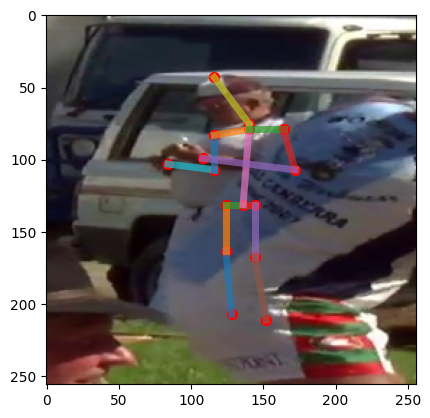


========== [Prediction] 모델 예측 ==========


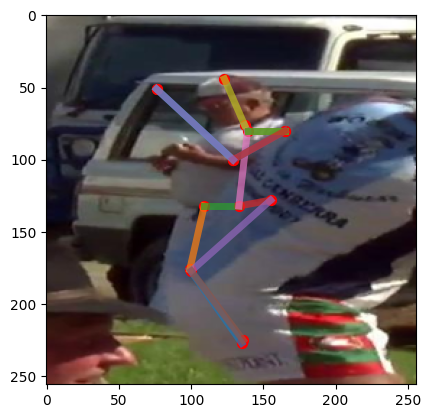

Validation Index: 2077

========== [Ground Truth] 정답 ==========


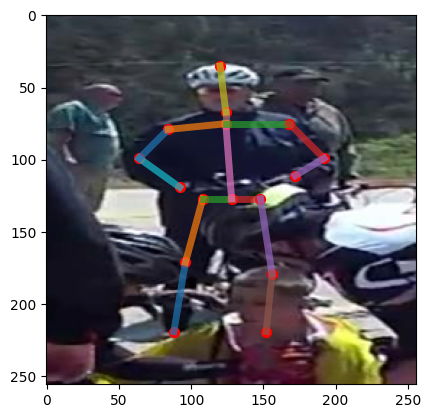


========== [Prediction] 모델 예측 ==========


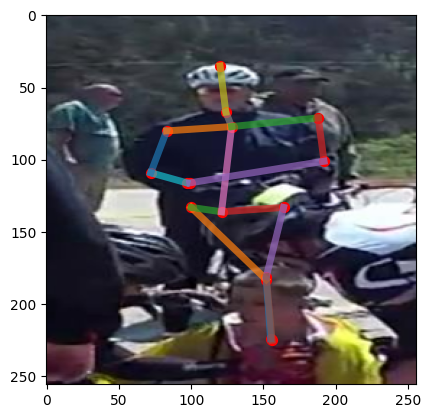

Validation Index: 1050

========== [Ground Truth] 정답 ==========


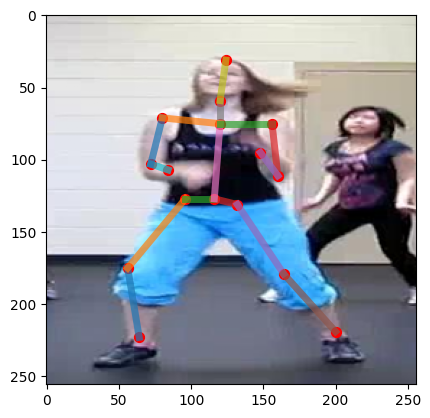


========== [Prediction] 모델 예측 ==========


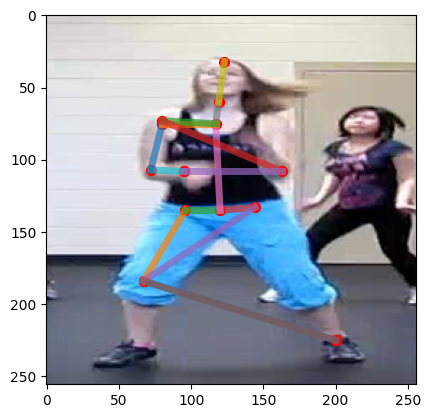

Validation Index: 1142

========== [Ground Truth] 정답 ==========


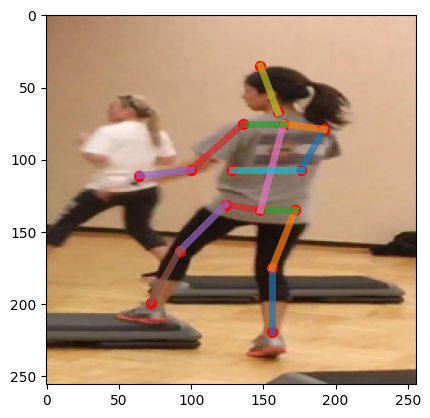


========== [Prediction] 모델 예측 ==========


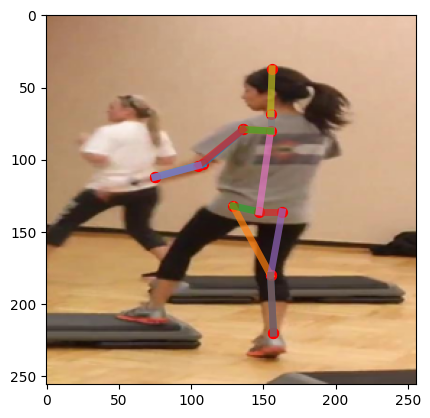

Validation Index: 1461

========== [Ground Truth] 정답 ==========


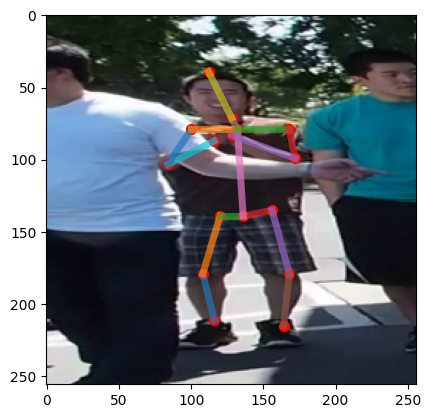


========== [Prediction] 모델 예측 ==========


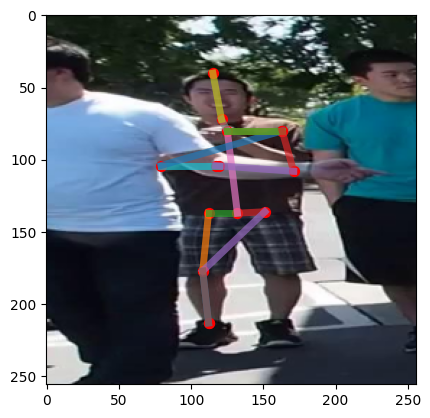

(pid=gcs_server) [2025-12-04 05:57:29,336 E 317097 317097] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-04 05:57:30,052 E 317178 317178] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(build_single_ptrecord pid=317226) [2025-12-04 05:57:30,502 E 317226 317295] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-04 05:57:30,679 E 317032 317223] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. 

In [ ]:
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 저장된 가중치 불러오기
WEIGHTS_PATH = os.path.join(MODEL_PATH_SIMPLEBASELINE, 'model-epoch-11-loss-0.1006.pt')
checkpoint = torch.load(WEIGHTS_PATH, map_location=device)

# 2. 새로운 state_dict 생성 (접두사 제거)
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    # 'module.' 이라는 접두사가 있으면 제거 ('module.conv1.weight' -> 'conv1.weight')
    name = k.replace("module.", "") 
    new_state_dict[name] = v

# 3. 모델에 로드
model = SimpleBaseline(num_heatmap=num_heatmap)
model.load_state_dict(new_state_dict)
model.to(device)
model.eval() # 평가 모드로 변경

# -------------------------------------------------------
# 결과 확인
# -------------------------------------------------------
for idx in [1752, 2077, 1050, 1142, 1461] :
    print(f"Validation Index: {idx}")
    # 데이터 가져오기
    img, gt_kp, pred_kp = compare_gt_and_pred(model, valid_dataset, idx)

    print("\n========== [Ground Truth] 정답 ==========")
    #draw_keypoints_on_image(img, gt_kp)
    #draw_skeleton_on_image(img, gt_kp)
    draw_keypoints_skeleton_on_image(img, gt_kp)

    print("\n========== [Prediction] 모델 예측 ==========")
    #draw_keypoints_on_image(img, pred_kp)
    #draw_skeleton_on_image(img, pred_kp)
    draw_keypoints_skeleton_on_image(img, pred_kp)



# 11. 정량적 평가 비교 (PCKh@0.5)

In [18]:
import torch
import numpy as np
from tqdm import tqdm

#////////////////////////////////////////////////////////////
# 1. PCKh 계산 함수 정의
#////////////////////////////////////////////////////////////
def compute_pckh(model, dataloader, device, threshold_ratio=0.5):
    """
    PCKh@0.5 성능을 측정하는 함수
    - model: 평가할 모델
    - dataloader: 검증 데이터 로더
    - device: GPU/CPU 장치
    - threshold_ratio: 머리 크기 대비 허용 오차 비율 (기본 0.5)
    """
    model.eval()
    correct_keypoints = 0
    total_visible_keypoints = 0
    
    with torch.no_grad():
        for images, target_heatmaps in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            target_heatmaps = target_heatmaps.to(device)
            
            # 모델 추론
            outputs = model(images)
            
            # 모델마다 출력 형식이 다를 수 있음 (Hourglass는 리스트 반환)
            if isinstance(outputs, list):
                pred_heatmaps = outputs[-1] # 마지막 스택의 히트맵 사용
            else:
                pred_heatmaps = outputs

            # 히트맵에서 (x, y) 좌표 추출을 위한 준비
            B, N, H, W = pred_heatmaps.shape
            
            # 1) Prediction 좌표 추출 (argmax)
            pred_heatmaps_flat = pred_heatmaps.view(B, N, -1)
            _, pred_indices = torch.max(pred_heatmaps_flat, dim=2)
            pred_x = pred_indices % W
            pred_y = pred_indices // W
            
            # 2) Ground Truth 좌표 및 Visibility 추출
            target_heatmaps_flat = target_heatmaps.view(B, N, -1)
            target_max_vals, target_indices = torch.max(target_heatmaps_flat, dim=2)
            target_x = target_indices % W
            target_y = target_indices // W
            
            # target 히트맵의 최대값이 0이면 해당 관절은 invisible한 것으로 간주
            visible_mask = target_max_vals > 0.1 

            # 3) 머리 크기(Head Size) 계산 (MPII: Neck(8) <-> Head Top(9))
            # 데이터 로더의 히트맵은 이미 Crop & Resize 되었으므로 히트맵 상의 거리로 근사 계산
            head_sizes = torch.sqrt((target_x[:, 9] - target_x[:, 8])**2 + (target_y[:, 9] - target_y[:, 8])**2)
            
            # 예외 처리: 머리 관절이 안 보여서 크기가 0인 경우, 이미지 너비의 10%로 대체
            head_sizes[head_sizes == 0] = W * 0.1
            
            # 배치 내 각 샘플별 Threshold 계산
            thresholds = head_sizes * threshold_ratio
            thresholds = thresholds.unsqueeze(1).expand_as(pred_x) # (B, N)으로 확장

            # 4) 거리 계산 및 정답 여부 판별
            distances = torch.sqrt((pred_x - target_x)**2 + (pred_y - target_y)**2)
            
            # 거리가 임계값보다 작고, 실제로 보이는(visible) 관절인 경우만 정답 처리
            correct = (distances <= thresholds) & visible_mask
            
            correct_keypoints += correct.sum().item()
            total_visible_keypoints += visible_mask.sum().item()

    # 전체 PCK 점수 계산
    pck_score = correct_keypoints / total_visible_keypoints if total_visible_keypoints > 0 else 0
    return pck_score

#////////////////////////////////////////////////////////////
# 2. 검증 데이터 로더 생성
#////////////////////////////////////////////////////////////
# batch_size는 메모리에 맞게 조절하세요.
val_loader = create_dataloader(VALID_JSON, IMAGE_PATH, batch_size=100, num_heatmap=num_heatmap, is_train=False)

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#////////////////////////////////////////////////////////////
# 3. 모델 준비 및 평가
#////////////////////////////////////////////////////////////
print("=== 성능 비교 시작 ===")

#################################
# (1) Hourglass 모델 평가
#################################

# 1. 저장된 가중치 불러오기
WEIGHTS_PATH = os.path.join(MODEL_PATH_HOURGLASS, 'model-epoch-15-loss-0.3941.pt')
checkpoint = torch.load(WEIGHTS_PATH, map_location=device)

# 2. 새로운 state_dict 생성 (접두사 제거)
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    # 'module.' 이라는 접두사가 있으면 제거 ('module.conv1.weight' -> 'conv1.weight')
    name = k.replace("module.", "") 
    new_state_dict[name] = v

# 3. 모델에 로드
model_hourglass = StackedHourglassNetwork(num_stack=4, num_residual=1, num_heatmap=num_heatmap).to(device)
model_hourglass.load_state_dict(new_state_dict)

print("Evaluating Stacked Hourglass Network...")
score_hg = compute_pckh(model_hourglass, val_loader, device)
print(f"Stacked Hourglass PCKh@0.5 Score: {score_hg:.4f}")


#################################
# (2) SimpleBaseline 평가
#################################

# 1. 저장된 가중치 불러오기
WEIGHTS_PATH = os.path.join(MODEL_PATH_SIMPLEBASELINE, 'model-epoch-11-loss-0.1006.pt')
checkpoint = torch.load(WEIGHTS_PATH, map_location=device)

# 2. 새로운 state_dict 생성 (접두사 제거)
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    # 'module.' 이라는 접두사가 있으면 제거 ('module.conv1.weight' -> 'conv1.weight')
    name = k.replace("module.", "") 
    new_state_dict[name] = v

# 3. 모델에 로드
model_simple = SimpleBaseline(num_heatmap=num_heatmap).to(device)
model_simple.load_state_dict(new_state_dict)


print("\nEvaluating SimpleBaseline...")
score_sb = compute_pckh(model_simple, val_loader, device)
print(f"SimpleBaseline PCKh@0.5 Score: {score_sb:.4f}")


###############################################
print("\n=== 결과 요약 ===")
print(f"Hourglass: {score_hg:.2%}")
print(f"SimpleBaseline   : {score_sb:.2%}")

=== 성능 비교 시작 ===
Evaluating Stacked Hourglass Network...


Evaluating: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


Stacked Hourglass PCKh@0.5 Score: 0.7532

Evaluating SimpleBaseline...


Evaluating: 100%|██████████| 30/30 [00:19<00:00,  1.58it/s]

SimpleBaseline PCKh@0.5 Score: 0.6388

=== 결과 요약 ===
Hourglass: 75.32%
SimpleBaseline   : 63.88%


# 12. Model paramter 수 확인

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 모델 인스턴스 생성 (이미 생성되어 있다면 그 변수를 사용)
model_hourglass = StackedHourglassNetwork(num_stack=4, num_residual=1, num_heatmap=num_heatmap).to(device)
model_simple = SimpleBaseline(num_heatmap=num_heatmap)
print(f"Hourglass Parameters:     {count_parameters(model_hourglass):,}")
print(f"SimpleBaseline Parameters: {count_parameters(model_simple):,}")

Hourglass Parameters:     16,251,392
SimpleBaseline Parameters: 27,184,720


# 13. 결과 분석 및 고찰

[실험 조건]
- 두 모델의 결과를 비교한다.  
- 두 모델 모두 epoch=20, batch_size = 44, lr = 0.001 으로 학습을 진행하였다.  
    - Hourglass는 lr=0.0007도 실험해보았으나 best validation loss에 큰 차이 없었음  
- 모델 성능 비교는 best validation loss의 model로 비교  
<br>
<br>

[결과 확인]
- (아래 그래프 확인) Loss 그래프를 보면 두 모델다 과적합 상태까지 epoch가 진행되었다.  
    - train loss는 계속 감소, validation loss는 유지되거나 약간 증가  
- (아래 그래프 확인) Loss 그래프를 보면 Hourglass 가 SimpleBaseline 보다 높게 나온다.  
    - 두 모델 모두 loss 계산은 같은 MSELoss, weighted_error를 사용하고 있다.  
    - 하지만, Hourglass는 num_stack=4로 설정되어 중간 단계의 출력을 포함한 4개 출력이 나오고  
    - 이 4개 출력으로 부터 각각의 loss를 구해 모두 더한값을 최종 loss로 사용하고 있다.  
    - 따라서, Hourglass의 Loss가 높은것 처럼 보이는 것은 당연하며,  
    - Loss 비교로 두 모델의 성능을 비교하는 것은 적절하지 않다고 생각된다.  
- (아래 그림 확인) 정성적 결과를 비교해보면 Hourglass가 SimpleBaseline 보다 조금 더 나은 성능을 보인다.  
    - 특히, 다른 물체에 가려지거나, 스스로의 신체가 곂치는 경우 좀 더 나은 성능을 보인다.  
    - 동적인 사진에서는 팔이나 손끝이 희미해서 잘 구분이 가지 않는 경우가 있는데, 이 경우에도 Hourglass가 더 나은 성능을 보인다.  
- (아래 PCKh@0.5 점수 비교 확인) 정량적 결과도 마찬가지로 Hourglass가 SimpleBaseline 보다 조금 더 나은 성능을 보임을 확인할 수 있다.  
<br>
<br>

[분석]
- SimpleBaseline이 더 나은 결과를 보일 줄 알았는데 반대의 결과가 나왔다. 고민해본 결과는 아래와 같다.  
    - a. Hourglass는 skip connection을 사용하여 upsample 과정에서 SimpleBaseline 보다 잃는 정보가 적다. 그래서 상대적으로 더 작고 디테일한 feature를 찾을 수 있고, 흐리거나 낮은 해상도를 가지는 feature도 상대적으로 잘 추출할 수 있을 것 같다.  
    - b. Hourglass는 Stacking으로 이미지를 작게 줄였다가 다시 키우는 과정을 여러 번 반복한다. 그리고 중간 간단계에서도 출력을 뽑아 loss를 계산한다. 이런 구조로 인해 상대적으로 가려진 부위를 추론하는 성능이 더 높지 않을가 생각된다.  
    - c. model parameter 수 에서도 차이가 난다.
        - Hourglass Parameters:     16,251,392  
        - SimpleBaseline Parameters: 27,184,720  


<br>
<br>
1. 학습 그래프(Loss)<br>
<img src='./markdown_fig/lossPlot.png' width='700'><br>
<br>
2. 정성적 결과 비교<br>
<img src='./markdown_fig/result.png' width='1200'><br>
<br>
3. PCKh@0.5 점수 비교<br>
Hourglass: 75.32%<br>
SimpleBaseline   : 63.88%<br>  
<br>
4. Model Parameter 수 비교<br>
Hourglass Parameters:     16,251,392<br>
SimpleBaseline Parameters: 27,184,720<br>